# Animal Image Dataset(DOG, CAT and PANDA)

## Dataset

https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

[Image]
* cats: "cats_0001.jpg ~ cats_1000.jpg" (1,000)
* dogs: "dogs_0001.jpg ~ dogs_1000.jpg" (1,000)
* panda: "panda_0001.jpg ~ panda_1000.jpg" (1,000)

In [1]:
# 상용 라이브러리
from glob import glob
import pandas as pd
import numpy as np
import cv2

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from skimage.transform import resize 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score  

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras.layers.core import Activation, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# 파일 불러오기
df = pd.read_csv("Animal_Image_64.csv")
print(df.shape)
df.head(2)

(3000, 12289)


,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,0.654480,0.534173,0.327607,0.667911,0.553844,0.329796,0.673979,0.562871,0.329573,0.676316,...,0.045762,0.130461,0.199240,0.055705,0.137738,0.180233,0.114157,0.163612,0.218687,0
1,0.477402,0.393786,0.362466,0.534961,0.436170,0.414788,0.530709,0.449573,0.461864,0.557825,...,0.124090,0.123012,0.108591,0.127805,0.159907,0.188738,0.238825,0.248253,0.262203,0


## Data EDA & Preprocessing

In [3]:
class_label = {0:'cat', 1:'dog', 2:'panda'}
imgR = 64
imgC = 64
channel = 3

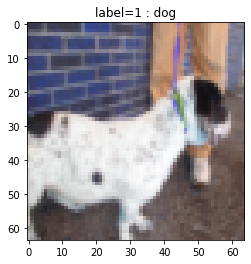

In [4]:
# Random Image Sample Visualization
rnd_idx = np.random.randint(df.shape[0], size=1)
plt.imshow(df.iloc[rnd_idx, :-1].values.reshape(imgR, imgC, channel))
plt.title(f"label={df.iloc[rnd_idx, -1].values[0]} : {class_label[df.iloc[rnd_idx, -1].values[0]]}")
plt.show()

In [5]:
# Constant Definition
# plot_Images
def plot_Images(nRow, nCol, df):
    df = df.reset_index(drop=True)
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4, nRow*4))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis=ax[i,j]
            axis.set_title(f"label={df.iloc[i*nCol+j, -1]}")
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(df.iloc[i*nCol+j, :-1].values.reshape(imgR, imgC, channel))
            plt.axis("off")
    plt.show()    
                    

<Figure size 432x288 with 0 Axes>

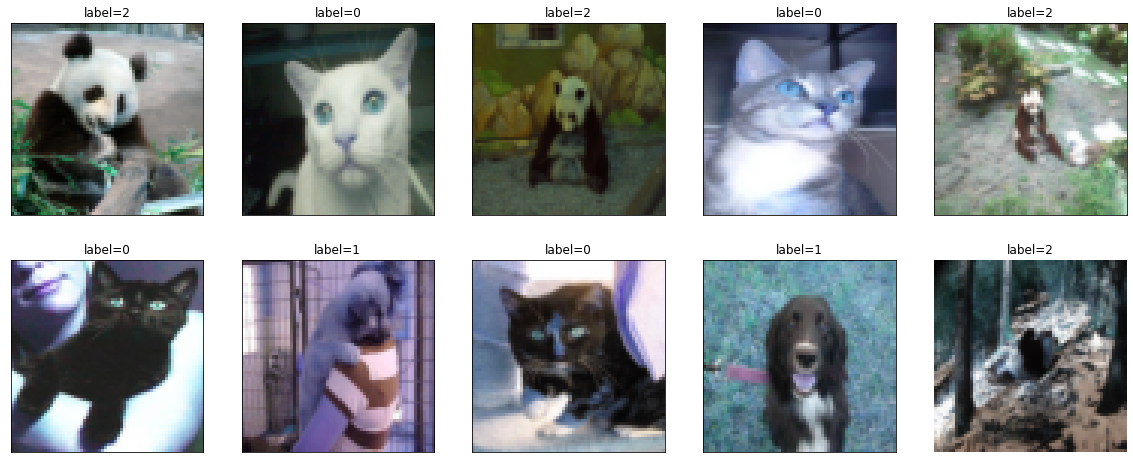

In [6]:
# Random Image Samples Visualization
random_idx = np.random.randint(df.shape[0], size=10)
plot_Images(2,5,df.iloc[random_idx])


### Data Split

In [7]:
# Data and Target Split
X = df.drop('label',axis=1)
y = df['label']

# train_valid_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=42, test_size=0.2, shuffle=True)

# Image Data Transformation
X_train = X_train.to_numpy().reshape(-1,imgR,imgC,channel)
X_valid = X_valid.to_numpy().reshape(-1,imgR,imgC,channel)
X_test = X_test.to_numpy().reshape(-1,imgR,imgC,channel)

print('X_train :',X_train.shape)
print('X_valid :',X_valid.shape)
print('X_test :',X_test.shape)
print('y_train :',y_train.shape)
print('y_valid :',y_valid.shape)
print('y_test :',y_test.shape)

X_train : (1920, 64, 64, 3)
X_valid : (480, 64, 64, 3)
X_test : (600, 64, 64, 3)
y_train : (1920,)
y_valid : (480,)
y_test : (600,)


0    640
2    640
1    640
Name: label, dtype: int64

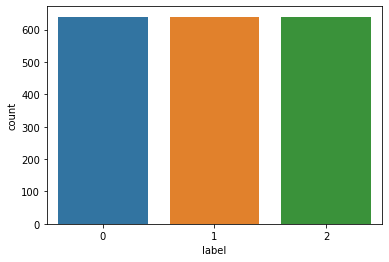

In [8]:
g = sns.countplot(y_train)

y_train.value_counts()

### Nomalization

In [9]:
# 정규화
x_train = X_train / 255
x_valid = X_valid / 255
x_test = X_test /255

x_train.shape, x_valid.shape, x_test.shape

((1920, 64, 64, 3), (480, 64, 64, 3), (600, 64, 64, 3))

### One-Hot Encoding

In [10]:
# One-Hot Encoding
y_train = pd.get_dummies(y_train).reset_index(drop=True)
y_valid = pd.get_dummies(y_valid).reset_index(drop=True)
y_test = pd.get_dummies(y_test).reset_index(drop=True)

y_train.shape, y_valid.shape, y_test.shape

((1920, 3), (480, 3), (600, 3))

## CNN

### Define the model

In [11]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2\
# -> Flatten ->Dense-> Dropout -> Out
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding="Same",
                 activation="relu", input_shape=(imgR,imgC,channel)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding="Same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same",
                 activation="relu", input_shape=(imgR,imgC,channel)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))

2022-07-17 14:09:06.630421: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 14:09:07.173755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6888 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e5:00.0, compute capability: 7.0


In [12]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                        

In [13]:
# Compile the model
model.compile(optimizer = "Nadam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [15]:
epochs = 30
batch_size=86

In [16]:
# Image Augmentation
datagen = ImageDataGenerator(
        rescale=1/255,
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=50, # randomly rotate images in the range (degrees, 0~180)
        zoom_range=0.1, # Randomly zoom image
        brightness_range=[0.8, 1.2],
        width_shift_range=0.1, # 이미지를 수평하게 랜덤으로 이동 (전체 너비의 크기)
        height_shift_range=0.1, # 이미지를 세로로 랜덤으로 이동 (전체 너비의 크기)
        horizontal_flip=False, # 랜덤하게 이미지 뒤집기
        vertical_flip=False, # 랜덤하게 이미지 뒤집기
        fill_mode = "nearest") 

datagen.fit(X_train)

In [22]:
# Fit the model
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid,y_valid),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
22/22 - 2s - loss: 0.7444 - accuracy: 0.6379 - val_loss: 0.6650 - val_accuracy: 0.6771 - lr: 0.0010 - 2s/epoch - 110ms/step
Epoch 2/30
22/22 - 2s - loss: 0.7362 - accuracy: 0.6478 - val_loss: 0.7416 - val_accuracy: 0.6250 - lr: 0.0010 - 2s/epoch - 106ms/step
Epoch 3/30
22/22 - 2s - loss: 0.7181 - accuracy: 0.6614 - val_loss: 0.6890 - val_accuracy: 0.6229 - lr: 0.0010 - 2s/epoch - 106ms/step
Epoch 4/30

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 - 2s - loss: 0.6868 - accuracy: 0.6745 - val_loss: 0.6807 - val_accuracy: 0.6562 - lr: 0.0010 - 2s/epoch - 106ms/step
Epoch 5/30
22/22 - 2s - loss: 0.6597 - accuracy: 0.6816 - val_loss: 0.5907 - val_accuracy: 0.7042 - lr: 5.0000e-04 - 2s/epoch - 109ms/step
Epoch 6/30
22/22 - 2s - loss: 0.6272 - accuracy: 0.6936 - val_loss: 0.6007 - val_accuracy: 0.7250 - lr: 5.0000e-04 - 2s/epoch - 107ms/step
Epoch 7/30
22/22 - 2s - loss: 0.6326 - accuracy: 0.6990 - val_loss: 0.5838 - val_accuracy: 0.7063 - l

## Evaludate the model

In [33]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy,lr
25,0.499268,0.759514,0.506631,0.754167,0.000063
26,0.507794,0.760087,0.496854,0.752083,0.000031
27,0.500213,0.754089,0.493296,0.756250,0.000031
28,0.497022,0.766630,0.493116,0.752083,0.000031
29,0.506199,0.763742,0.486724,0.760417,0.000016


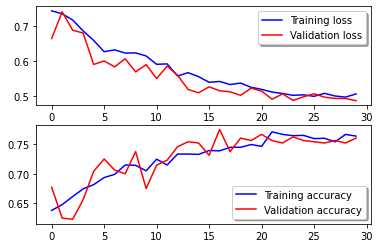

In [23]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [34]:
# 예측값
y_pred = model.predict(X_test).flatten()
y_pred.shape

(1800,)

In [35]:
# 임계값:0.5
y_predict = (y_pred > 0.5).astype(int)
y_predict

array([0, 0, 1, ..., 1, 0, 0])

In [36]:
# 테스트 정확도
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\ntest_acc: ", test_acc)
print("\ntest_loss: ", test_loss)

19/19 [==============================] - 0s 10ms/step - loss: 0.5674 - accuracy: 0.7150

test_acc:  0.7149999737739563

test_loss:  0.5673917531967163
